## Introduction

## Imports and setup

In [312]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [313]:
# Imports
import pandas as pd
import polars as pl
import numpy as np
from functools import wraps
import time
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [314]:
sns.set_theme(palette="pastel")

The definition of each feature are available [here](https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data).


In [315]:
converters = {
    'OSEBuildingID': str,
    'YearsENERGYSTARCertified':str,
    }
building_energy_benchmarking = pd.read_csv("2016_Building_Energy_Benchmarking.csv", converters=converters)

In [316]:
# time decorator to quickly measure efficiency of functions
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Execution of function {func.__name__} took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## Data exploration

In [317]:
building_energy_benchmarking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   object 
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

_Note : GFA means Gross Floor Area_

In [318]:
# Remove empty columns
removed_columns = building_energy_benchmarking.loc[:, building_energy_benchmarking.isna().all()].columns
building_energy_benchmarking.dropna(axis=1, how="all", inplace=True)
print(f"""{len(removed_columns)} columns were removed:\n{"\n".join(removed_columns)}""")

1 columns were removed:
Comments


In [319]:
building_energy_benchmarking.describe()

,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,...,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,...,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,...,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,...,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,...,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,...,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,...,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,...,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [320]:
def remove_non_wrods_chars(s:str, escape_chars:list=[]):
    ''' 
    Removes non words characters (even whitespaces) and set to lower case.
    Used to detect hidden missing values ('N/A', 'UNKNOWN', ...)
    '''
    if pd.isnull(s):
        return s
    escape_pattern = ''.join(re.escape(char) for char in escape_chars)
    pattern = r'[^\w' + escape_pattern + r']|_'
    return re.sub(pattern, '', str(s), flags=re.UNICODE).lower()

In [321]:
def find_hidden_missing_values(df:pd.DataFrame, standardize:bool=True, print_result:bool = True, impute_nan:bool=False, additional_hidden_null_values:list[str] = ["unknown", "null", "nan", "na", "0", "inconnu", "unavailable", "not stated"]):   
    df_copy = df.copy()

    for col in df_copy:
        if standardize:
            data = df_copy[col].map(remove_non_wrods_chars)
        else:
            data = df_copy[col]
        contains_alphanumeric = data.str.contains(pat=r'\w', na=True, regex=True)
        hidden_null_values_condition = ~contains_alphanumeric | data.isin(additional_hidden_null_values)
        
        if hidden_null_values_condition.any():
            if print_result:
                hidden_null_values = df_copy.loc[hidden_null_values_condition, col]
                print(f"""
{hidden_null_values.shape[0]} values in '{col}' can be considered as null values:
{hidden_null_values}
{'*'*30}""")
            if impute_nan:
                df_copy.loc[hidden_null_values_condition, col] = np.nan
    
    if impute_nan:
        return df_copy

In [322]:
building_energy_benchmarking_objects_cols = building_energy_benchmarking.select_dtypes(include=object).columns
building_energy_benchmarking[building_energy_benchmarking_objects_cols] = find_hidden_missing_values(building_energy_benchmarking[building_energy_benchmarking_objects_cols], impute_nan=True)


3257 values in 'YearsENERGYSTARCertified' can be considered as null values:
0        
1        
2        
3        
4        
       ..
3371     
3372     
3373     
3374     
3375     
Name: YearsENERGYSTARCertified, Length: 3257, dtype: object
******************************


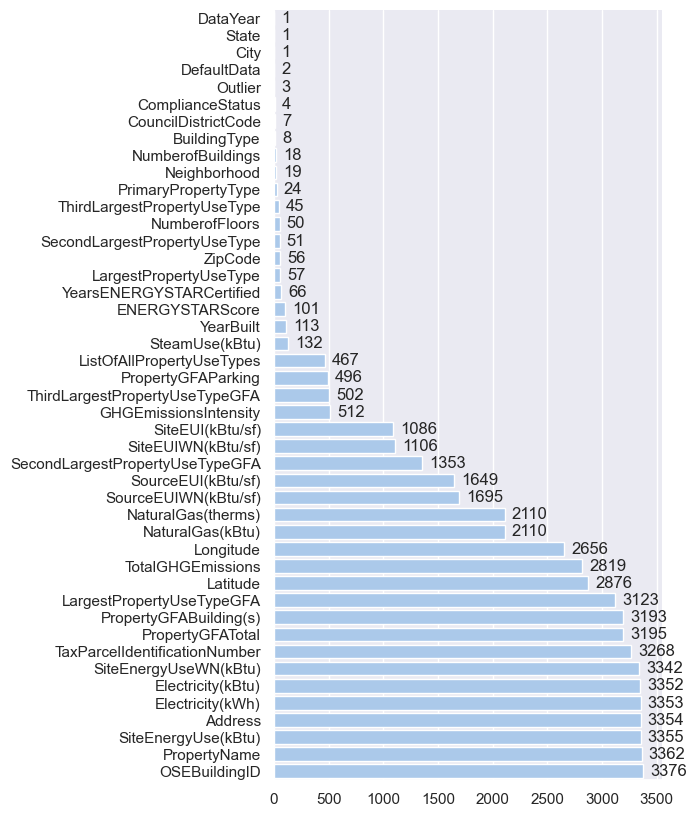

In [323]:
fig, ax = plt.subplots(figsize=(5,10))
unique_values_count = building_energy_benchmarking.apply(lambda s: len(s.unique()))
sns.barplot(data=unique_values_count, ax=ax, orient='h', order=unique_values_count.sort_values(ascending=True).index)
ax.spines[['right', 'top']].set_visible(False)
for i in range(len(ax.containers)):
  ax.bar_label(ax.containers[i], padding=5)

In [324]:
building_energy_benchmarking[["DataYear", "State", "City"]].value_counts(normalize=True)

DataYear  State  City   
2016      WA     Seattle    1.0
Name: proportion, dtype: float64

Every single building is located in Seattle in the state of Washington, and data is from 2016.  
Columns "DataYear", "State" and "City" can be removed.

In [325]:
building_energy_benchmarking.drop(["DataYear", "State", "City"], axis=1, inplace=True)

In [326]:
# Only keep non residential buildings
relevant_building_types = ["NonResidential", "Nonresidential COS", "SPS-District K-12", "Campus", "Nonresidential WA"] # SPS-District K-12 describes Seattle Public Schools
building_energy_benchmarking = building_energy_benchmarking.loc[building_energy_benchmarking["BuildingType"].isin(relevant_building_types)]

In [327]:
LISTLIKE_COLS = ["ListOfAllPropertyUseTypes", "YearsENERGYSTARCertified"]

In [328]:
def all_property_use_types_to_list(s:str):
  if isinstance(s, str):
    return re.split(r',\s*(?![^()]*\))', s)
  return s

In [329]:
def years_energy_star_certified(s:str):
  if isinstance(s, str):
    n=4
    return [s[i:i+n] for i in range(0, len(s), n)]
  return s

In [330]:
# Preprocessing some variables
building_energy_benchmarking["ListOfAllPropertyUseTypes"] = building_energy_benchmarking["ListOfAllPropertyUseTypes"].apply(all_property_use_types_to_list)
building_energy_benchmarking["YearsENERGYSTARCertified"] = building_energy_benchmarking["YearsENERGYSTARCertified"].apply(years_energy_star_certified)
building_energy_benchmarking["Neighborhood"] = building_energy_benchmarking["Neighborhood"].str.lower()
building_energy_benchmarking.loc[building_energy_benchmarking["Neighborhood"] == "delridge neighborhoods", "Neighborhood"] = "delridge"

In [331]:
def overview_univariate_distributions(df:pd.DataFrame):
  for col in df:#.select_dtypes(include=object):
      data = df[col].copy()
      if col in LISTLIKE_COLS:
        data = data.explode()
        try:
          data = data.astype(float)
        except:
          data = data
      dtype = data.dtype
      total = data.count()
      value_counts = data.value_counts()
      entropy_value = entropy(value_counts)
      if (entropy_value < 2 and len(value_counts) > 10) or (value_counts >= 0.03*total).all():  # Arbitrary threshold
        if value_counts[value_counts < 0.03*total].any():
          significant_values = value_counts[value_counts >= 0.03*total]
          other_count = value_counts[value_counts < 0.03*total].sum()
          value_counts = pd.concat([significant_values, pd.Series({'Other (auto)': other_count})])       
        fig, ax = plt.subplots(figsize=(6,6))
        sns.set_style("whitegrid")
        ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
        ax.set_title(f"Overview of the distribution of {col}")
      elif dtype == "float64" or dtype == "int64":
        unique_values = data.unique()
        fig, axes = plt.subplots(2, figsize=(10,6), sharex=True, height_ratios=[1,0.2], gridspec_kw={'hspace':0})
        sns.histplot(data=data, ax=axes[0], kde=len(unique_values)>=50, bins=min(len(unique_values), 50), discrete=len(unique_values)<50)
        sns.boxplot(data=data, ax=axes[1], orient='h')
        fig.suptitle(f"Distribution of {col}", y=1)
        fig.tight_layout()
      else:
        fig, ax = plt.subplots(figsize=(10,5))
        sns.barplot(value_counts.iloc[:20], ax=ax, orient='h')
        ax.set_title(f"Overview of the distribution of {col}")

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_25032\1984228033.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,5))


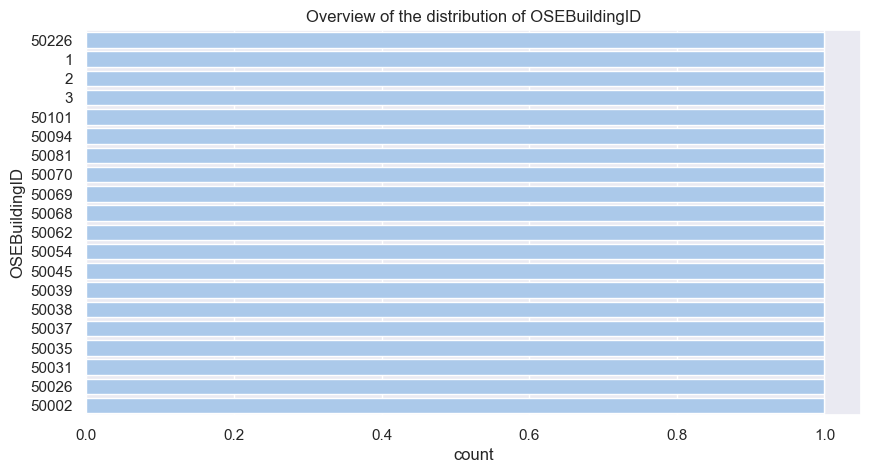

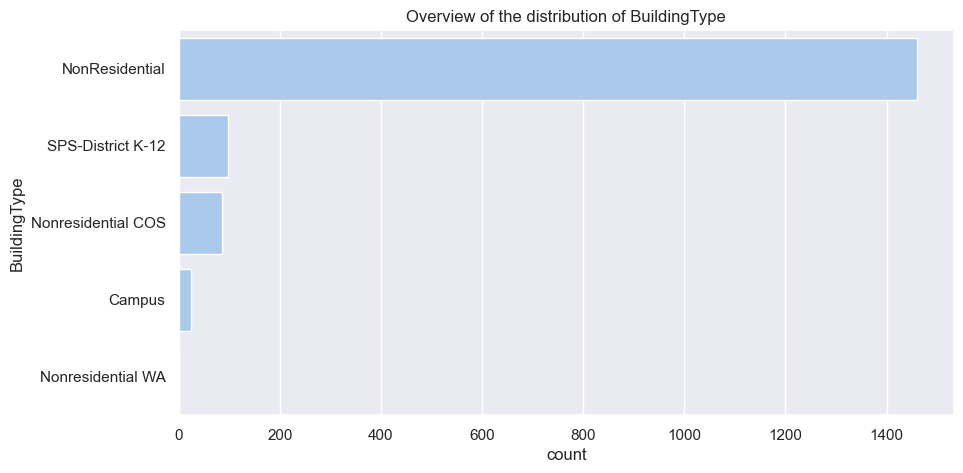

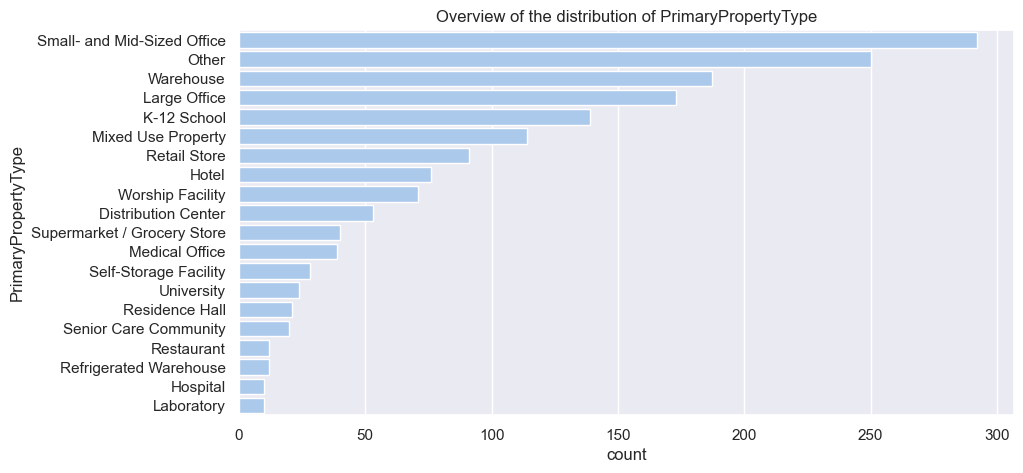

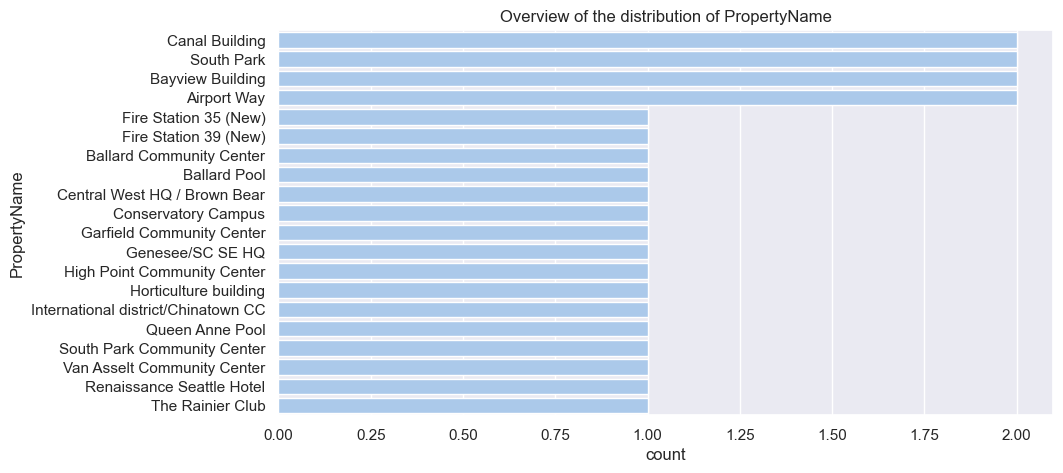

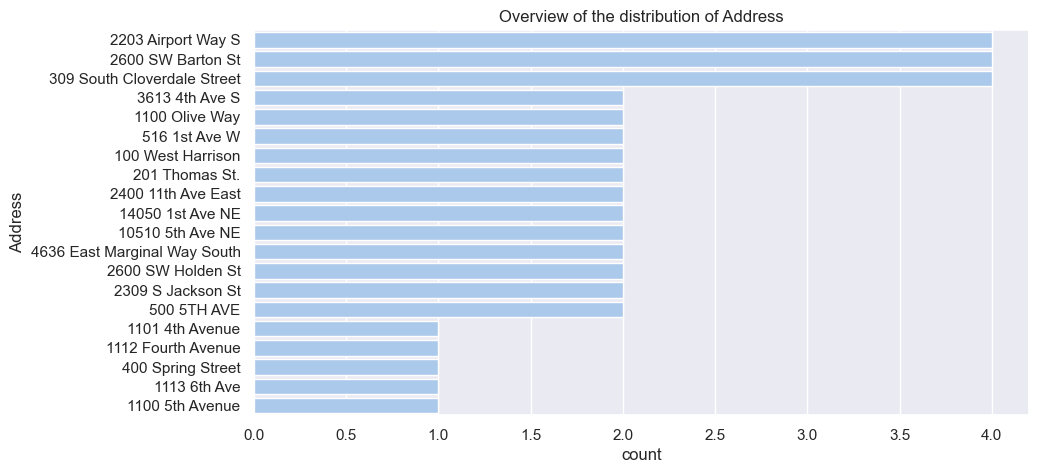

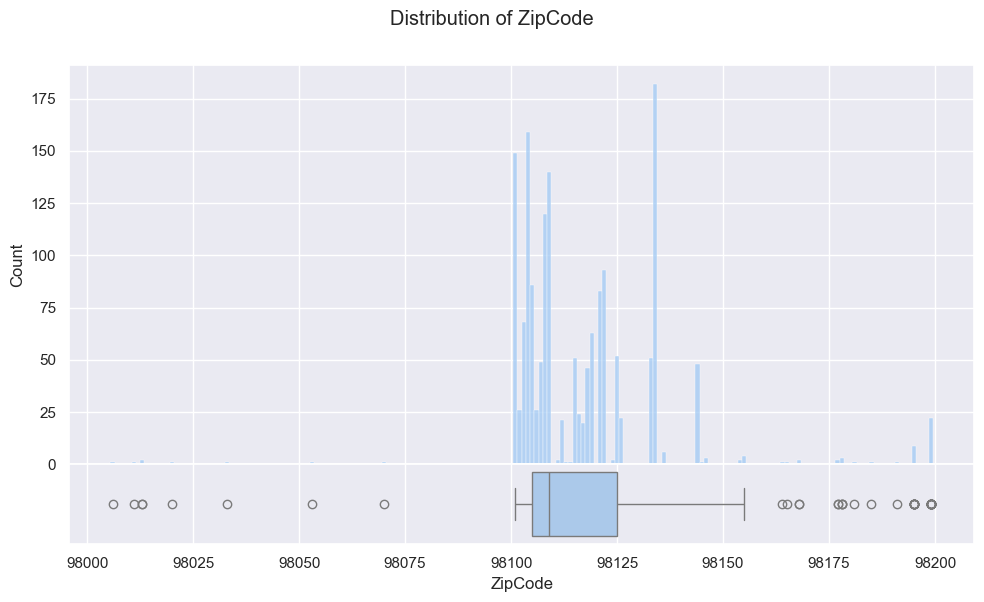

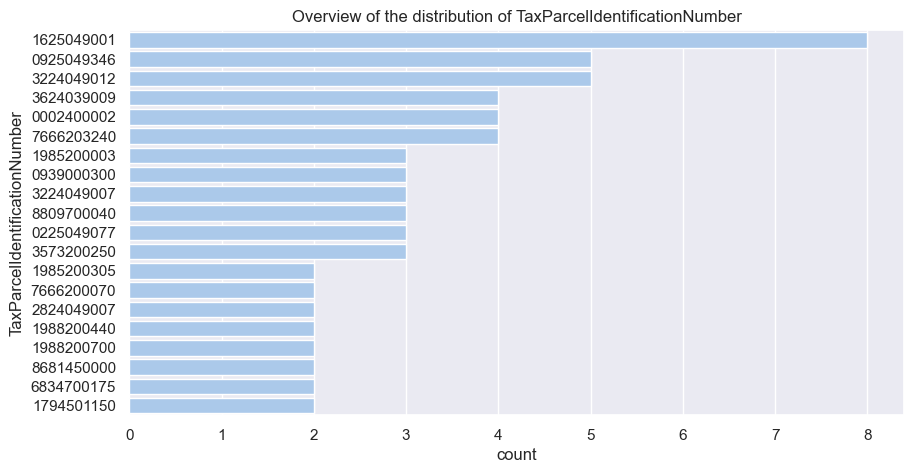

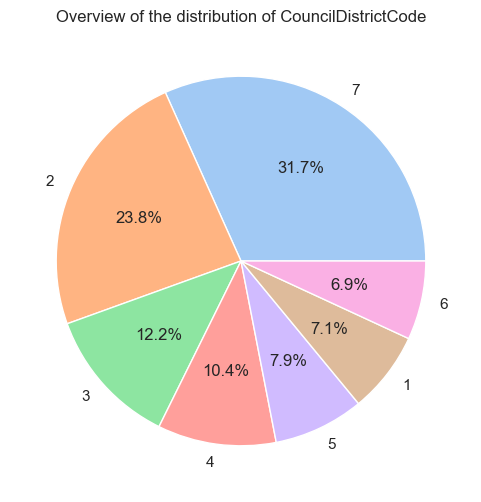

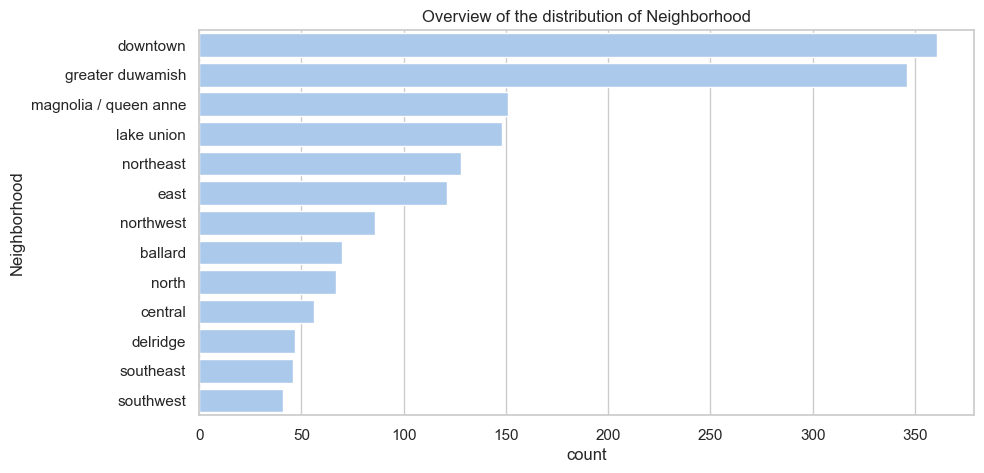

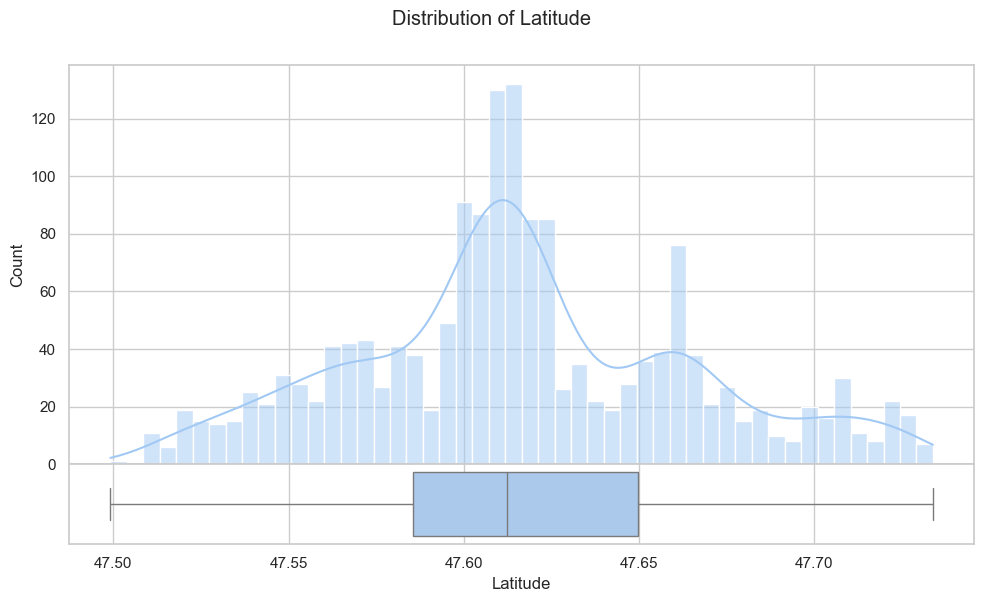

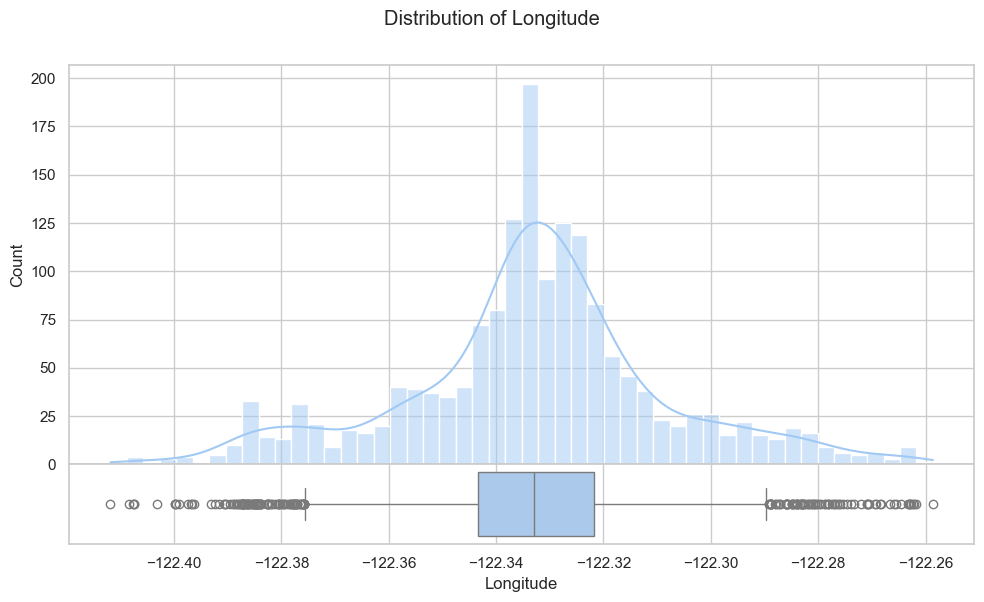

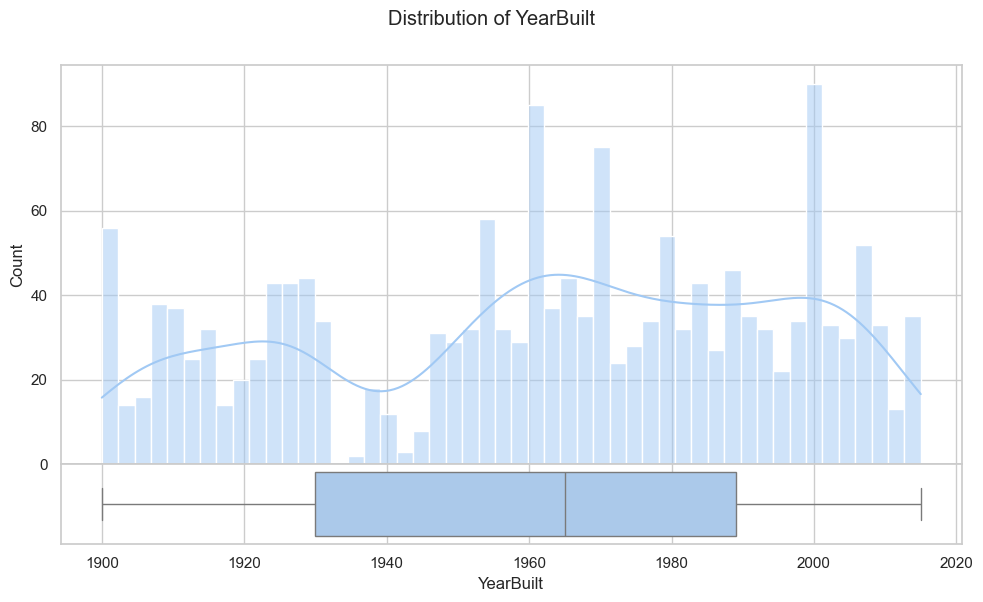

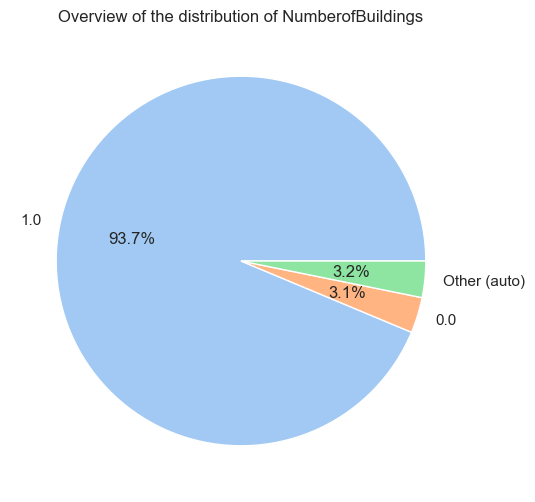

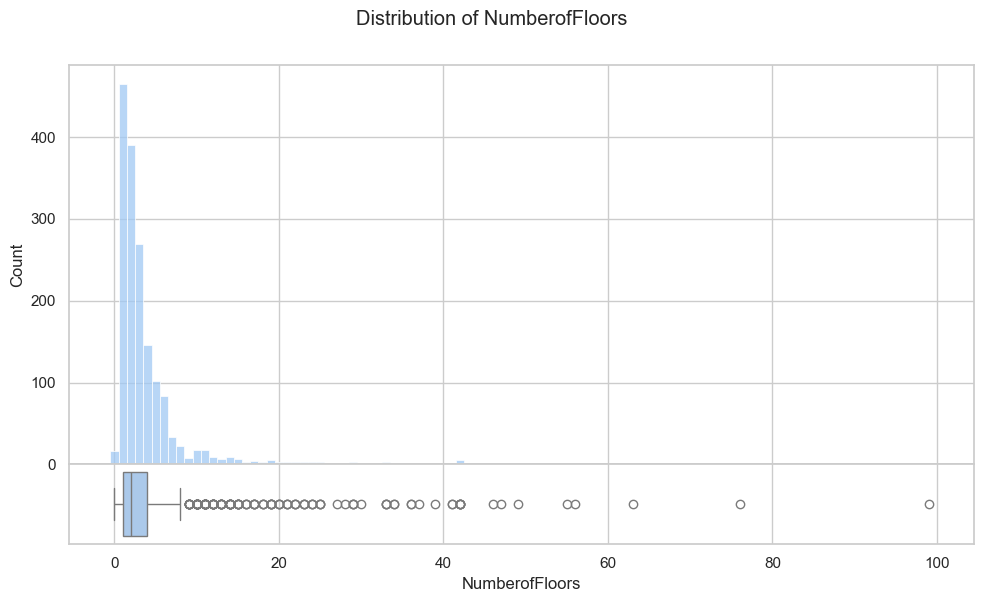

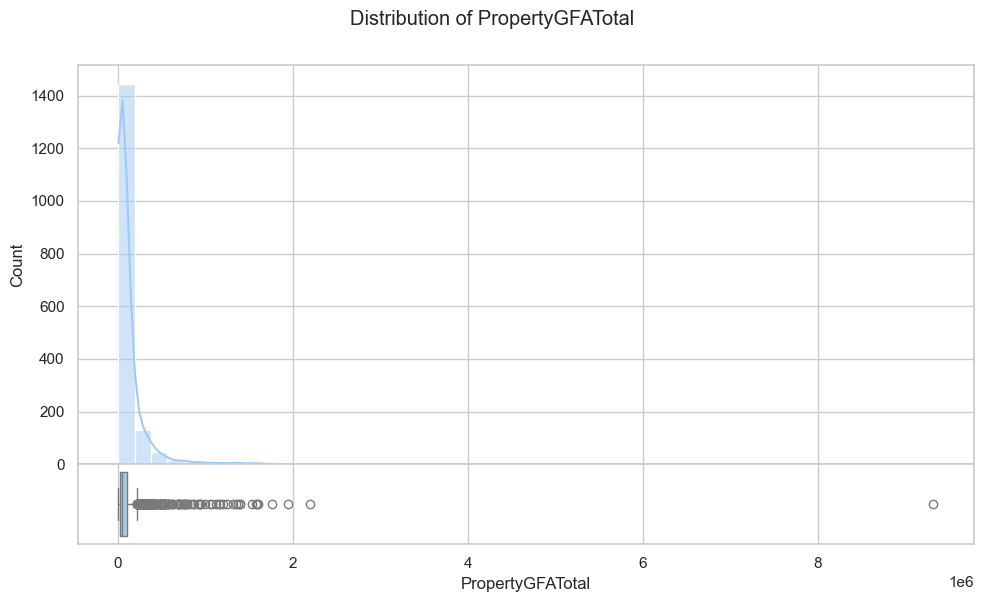

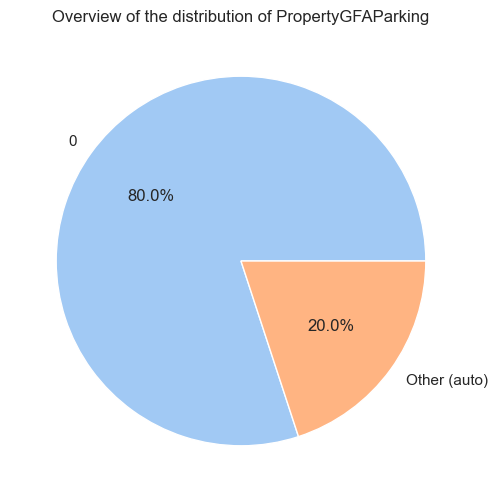

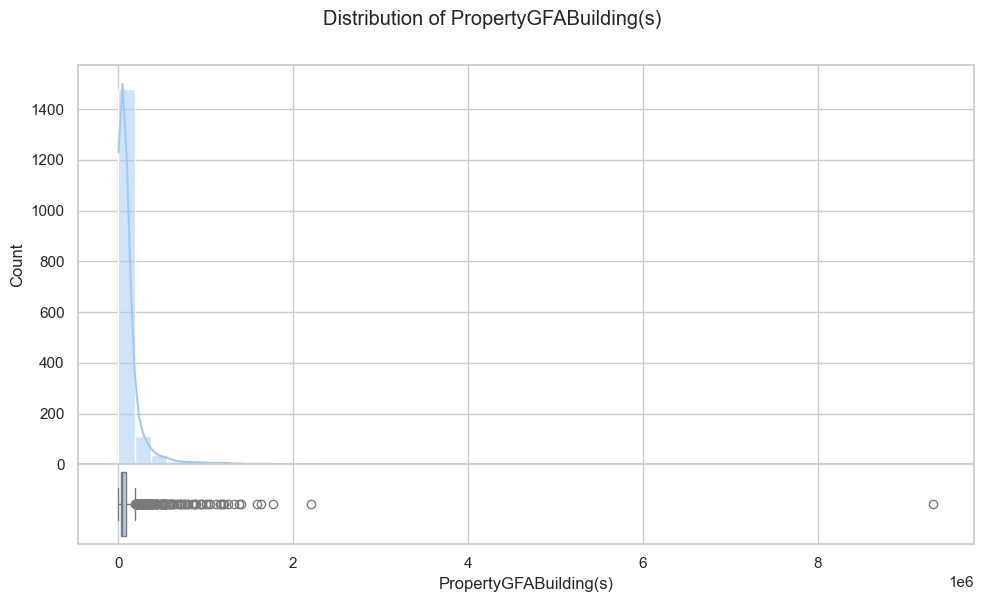

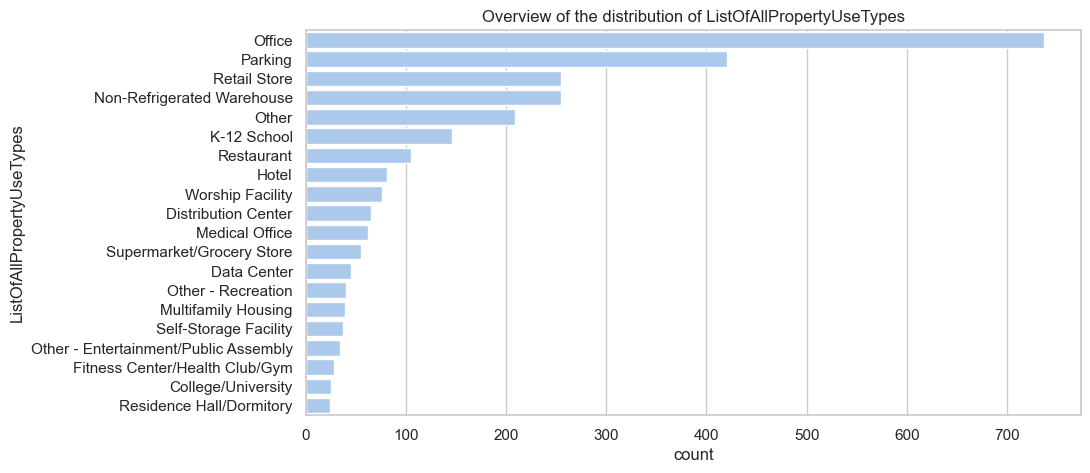

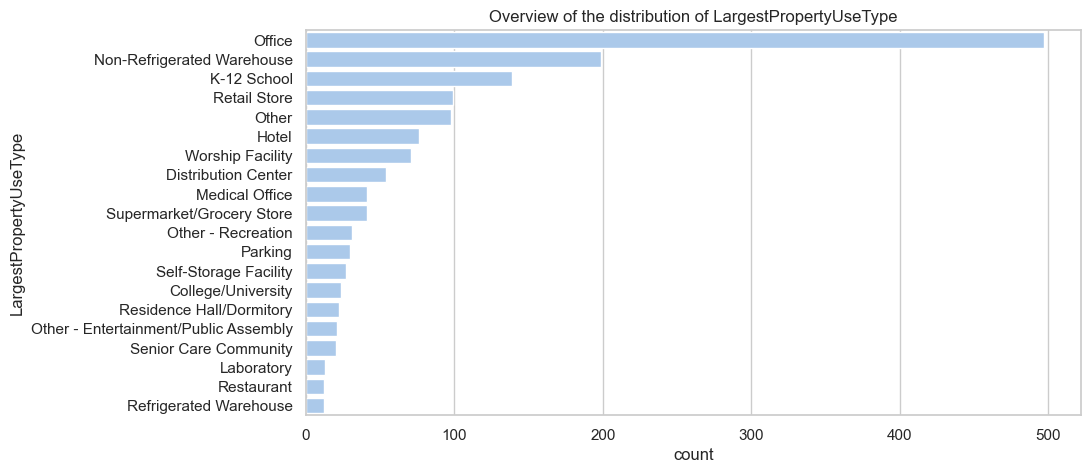

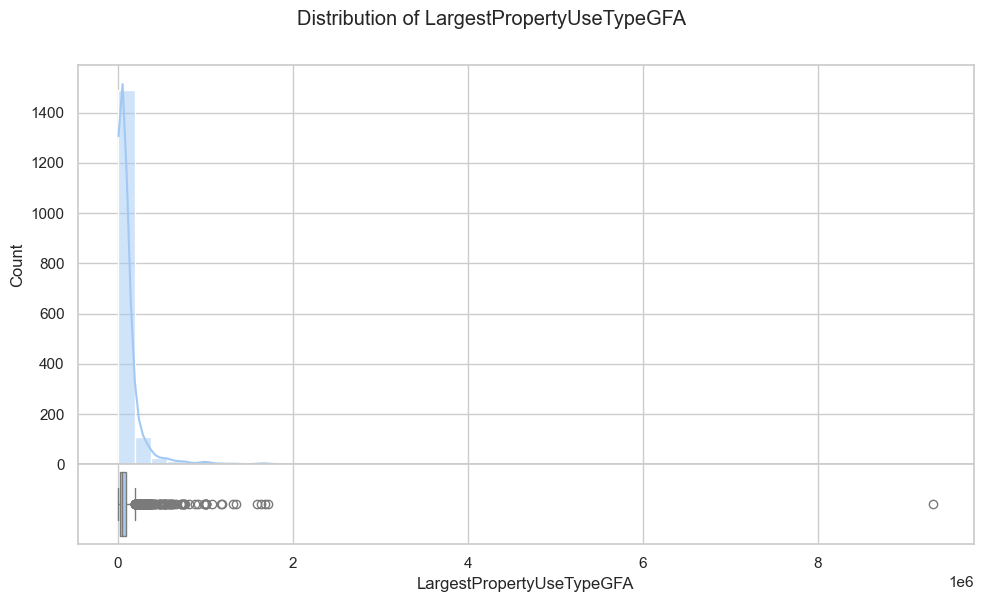

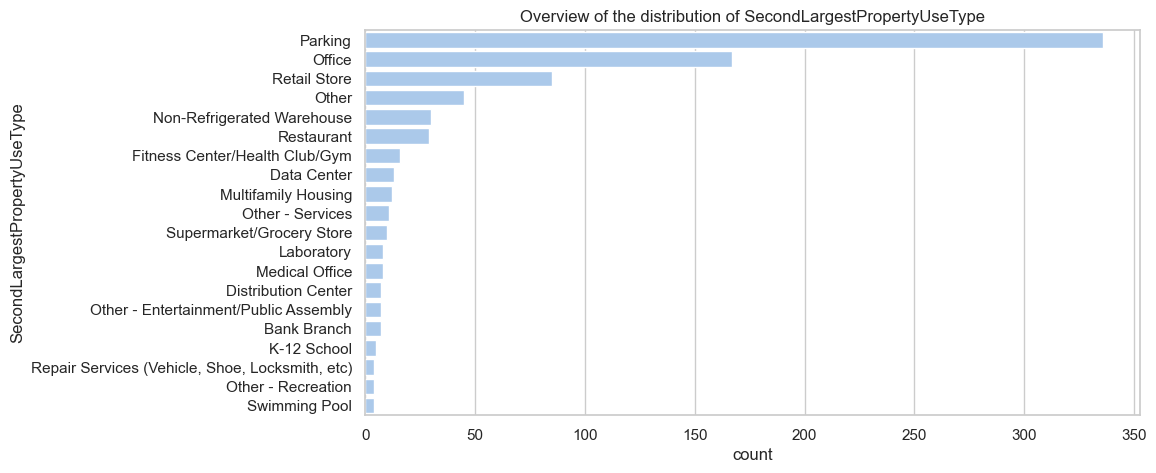

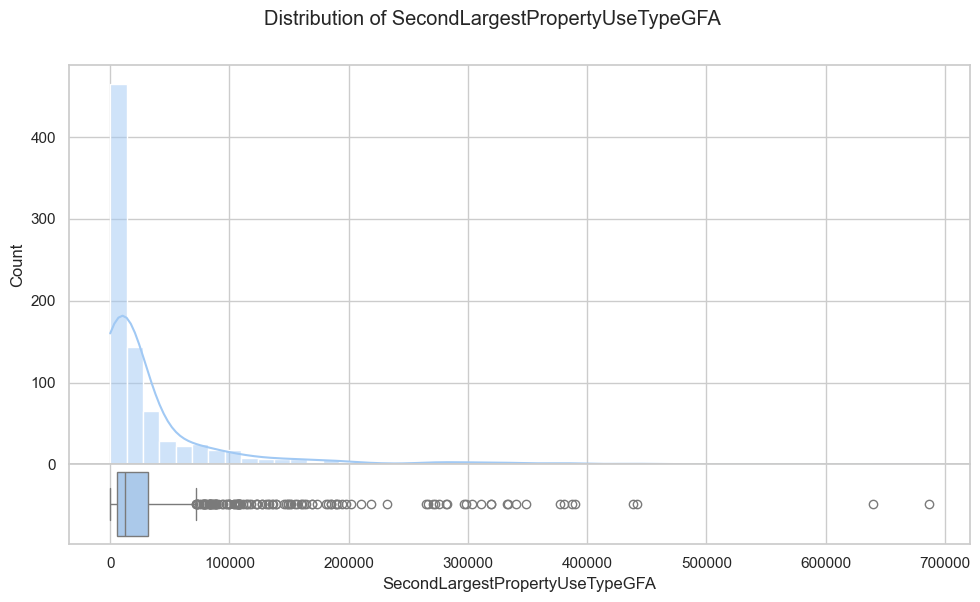

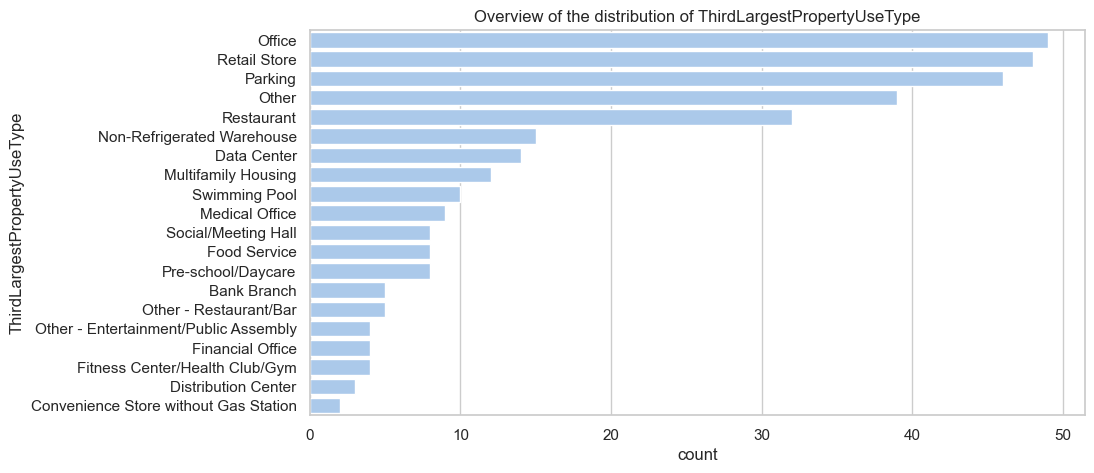

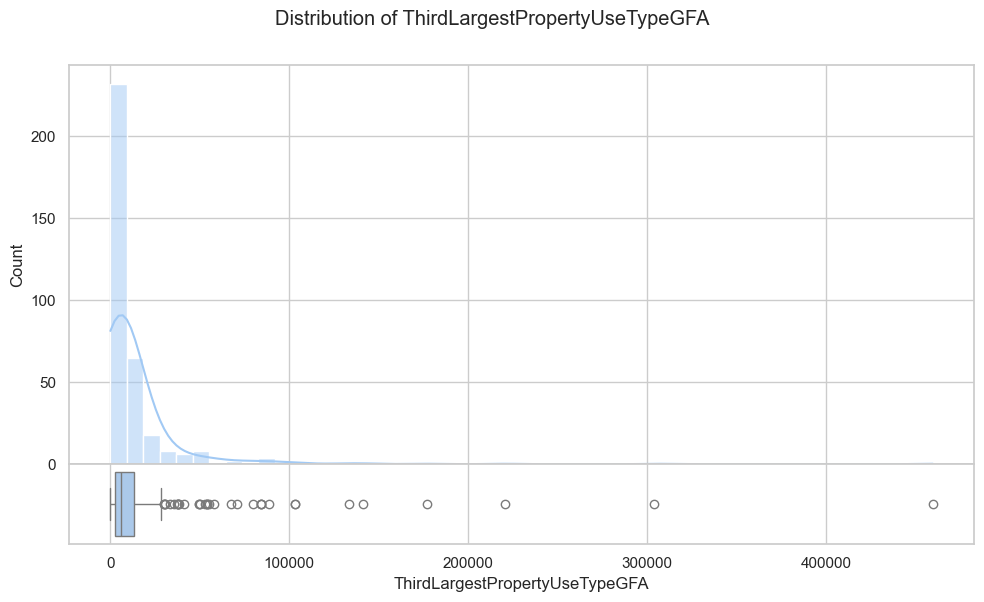

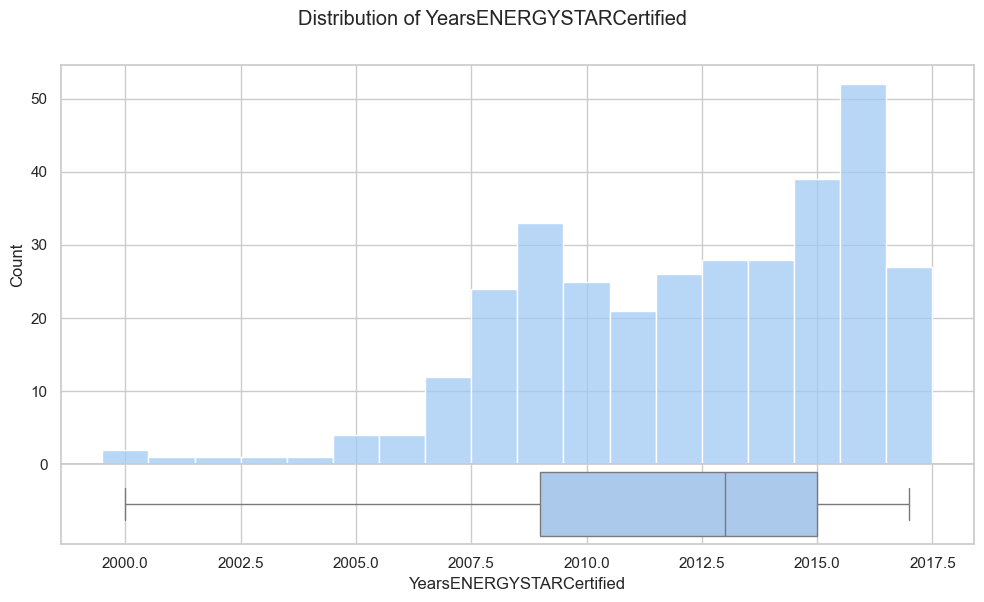

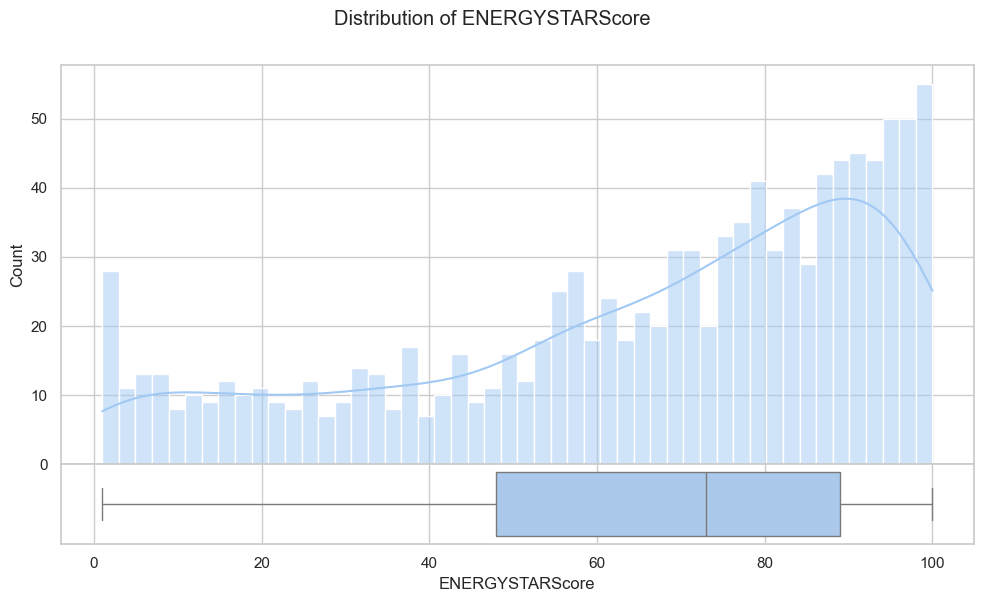

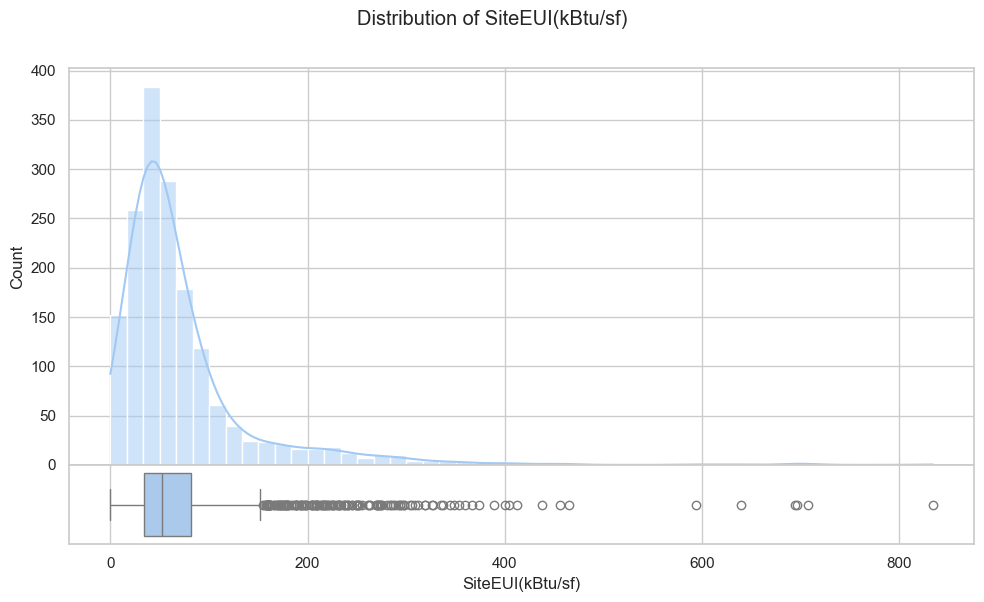

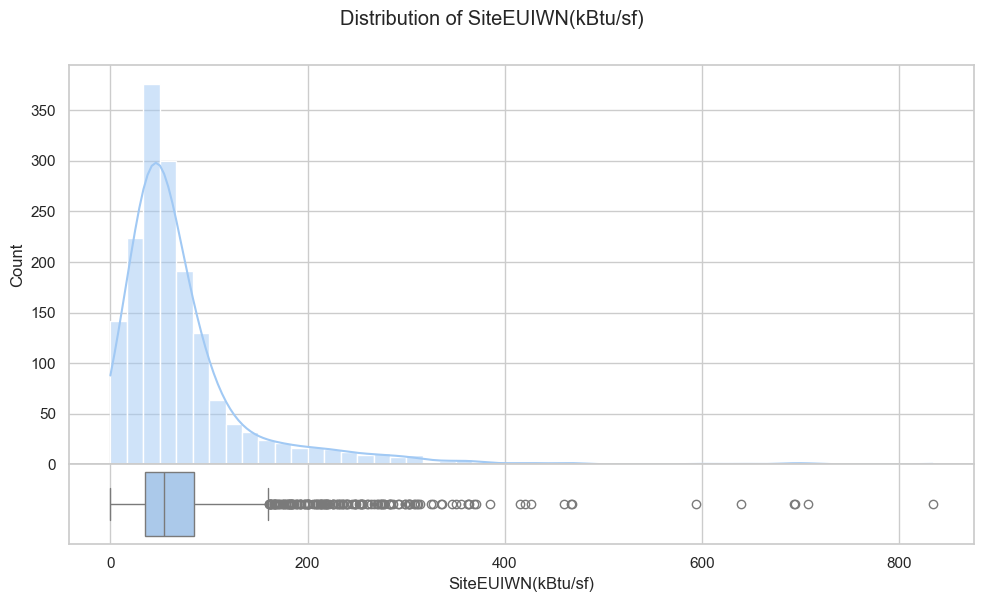

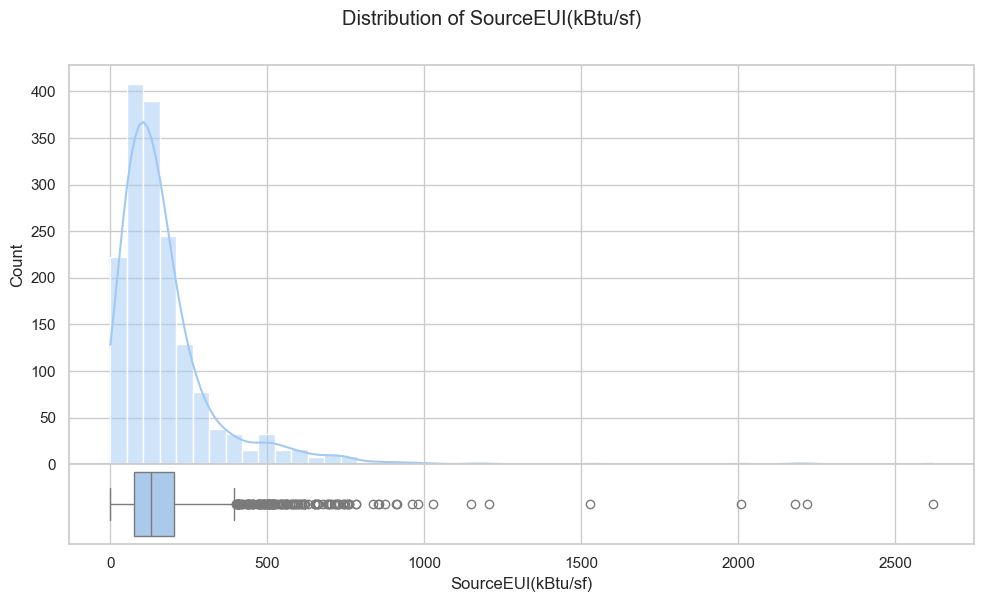

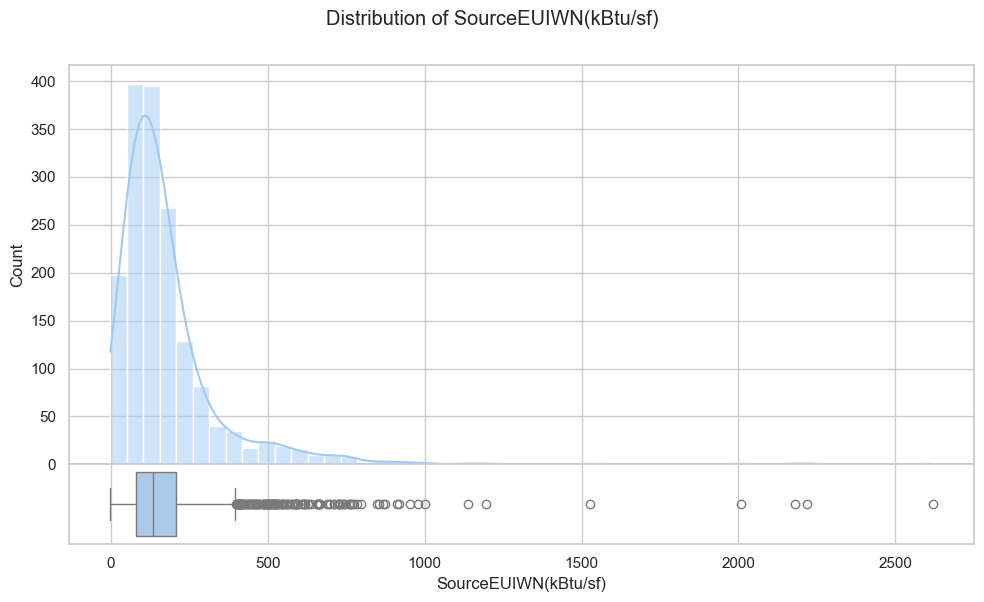

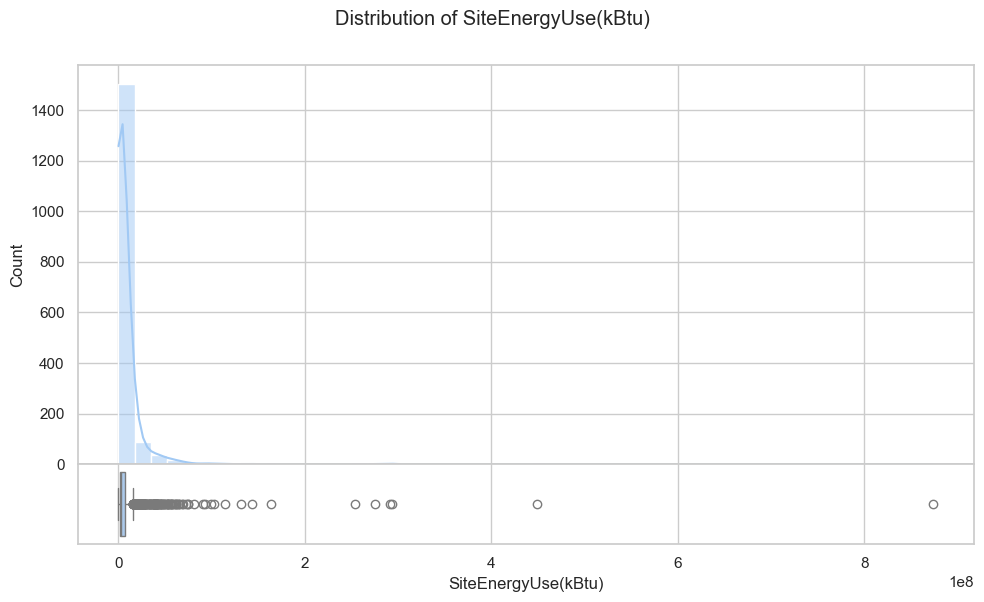

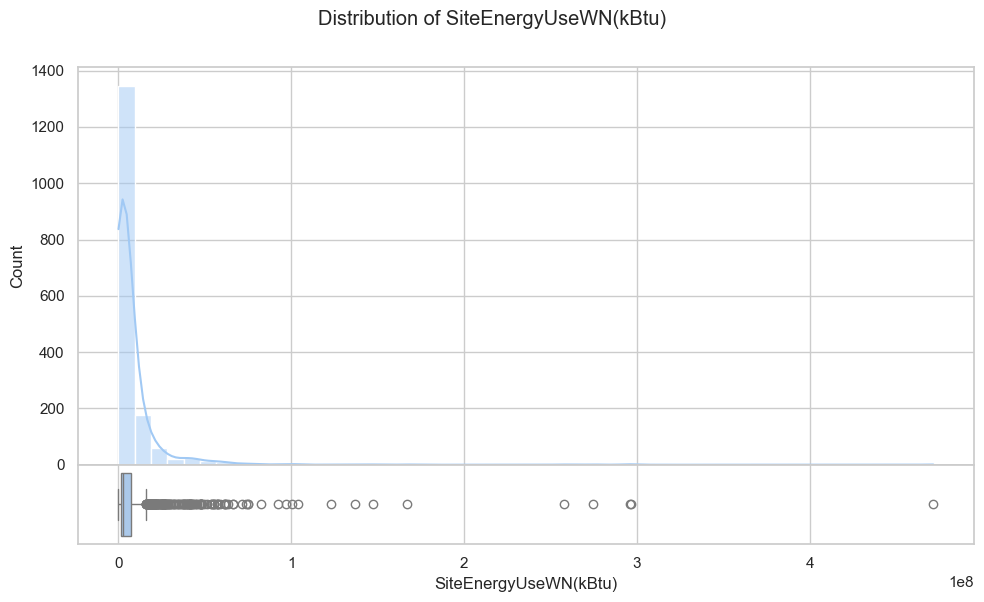

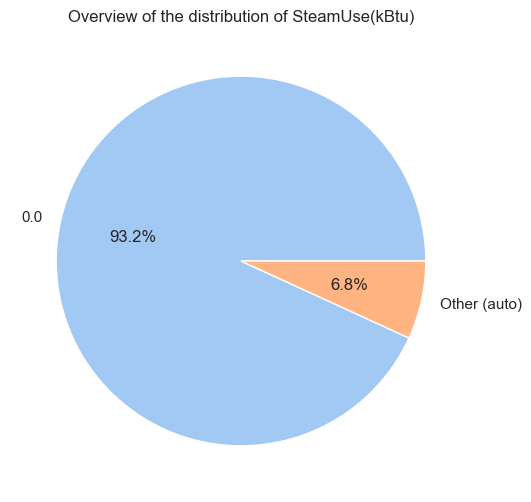

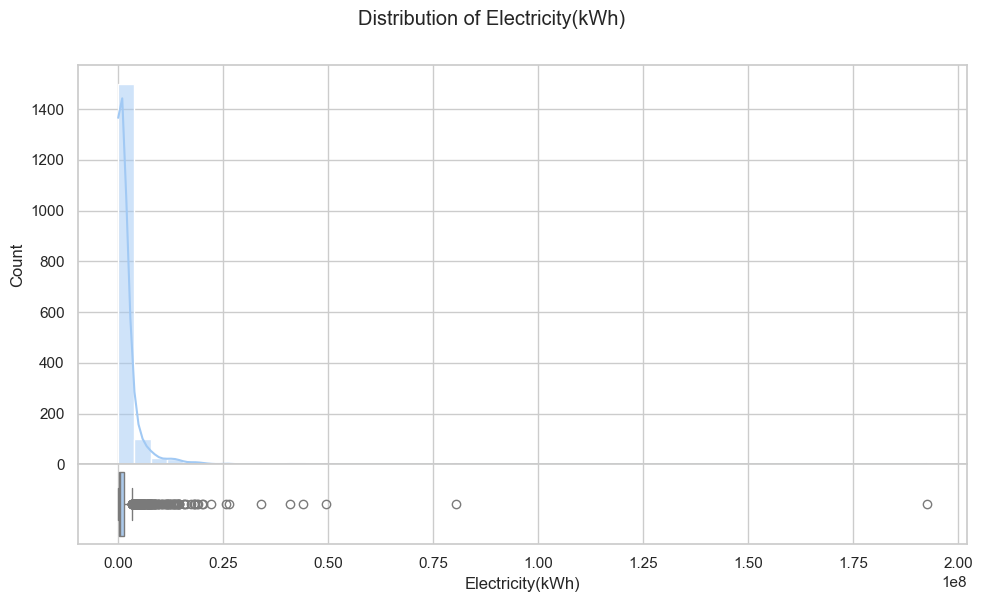

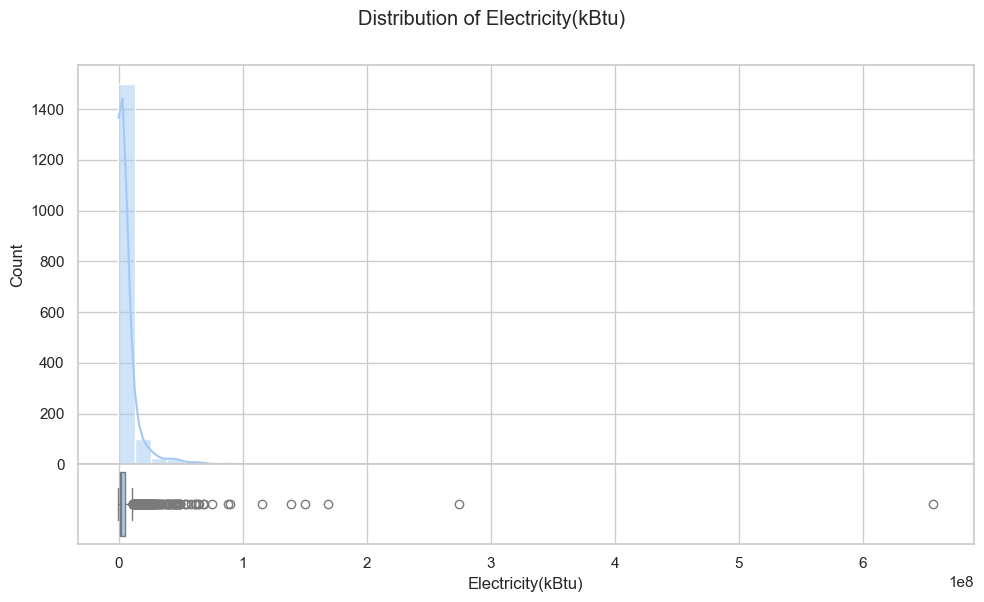

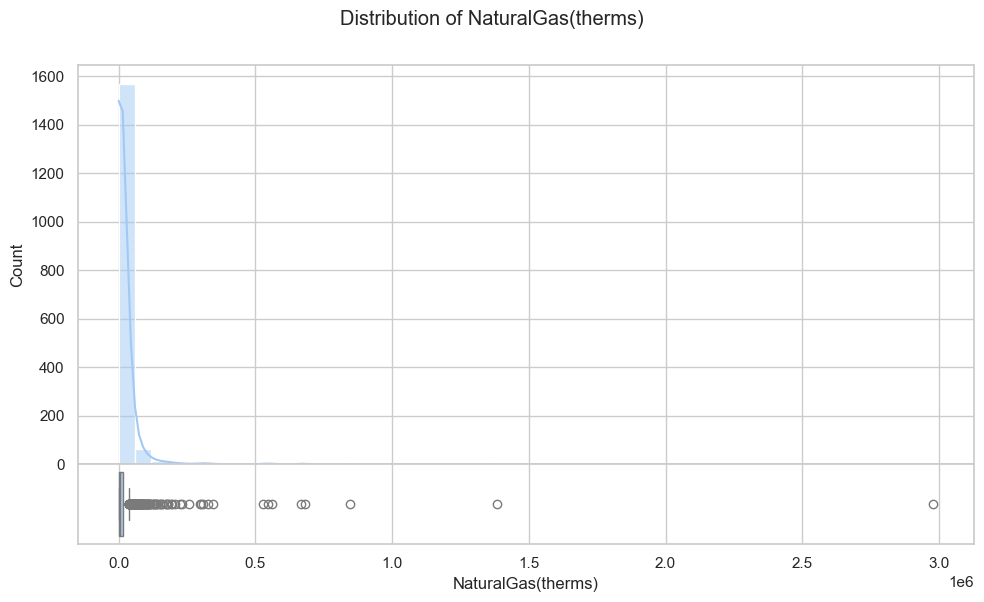

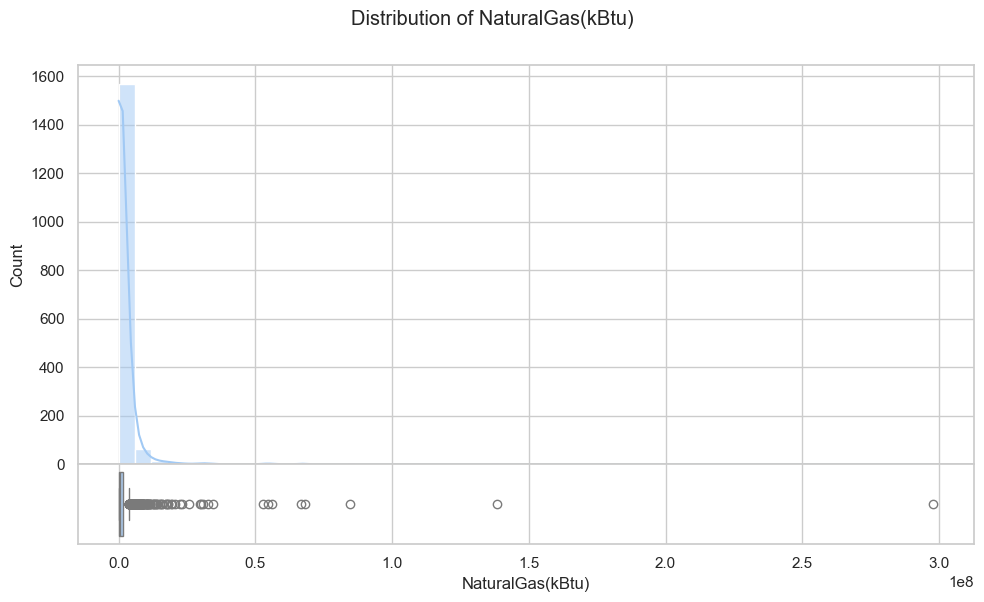

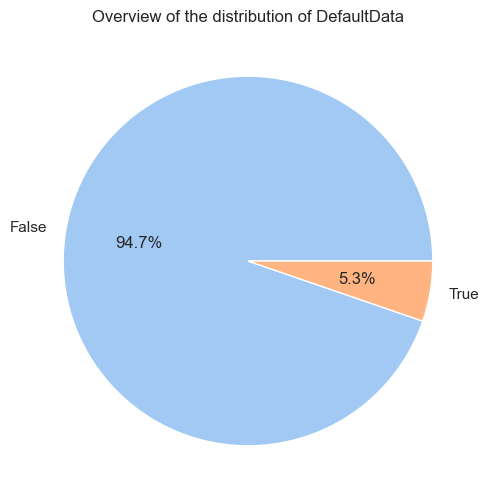

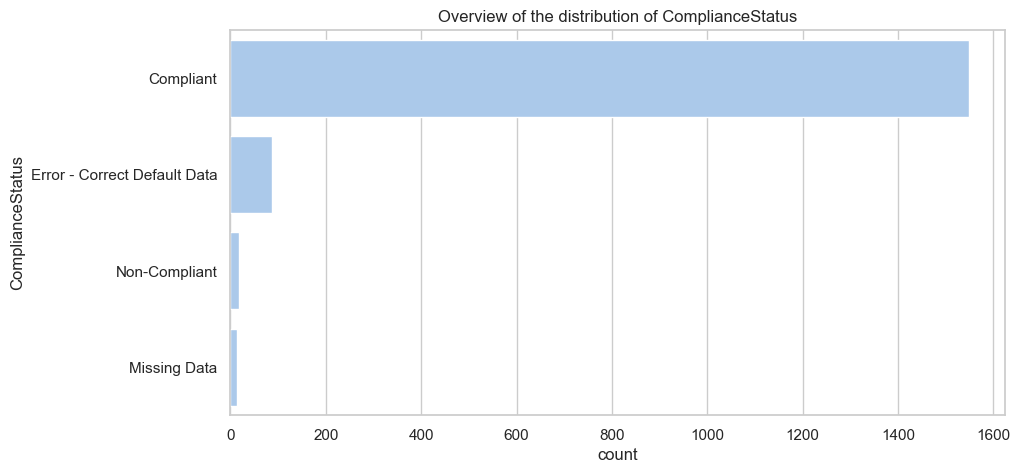

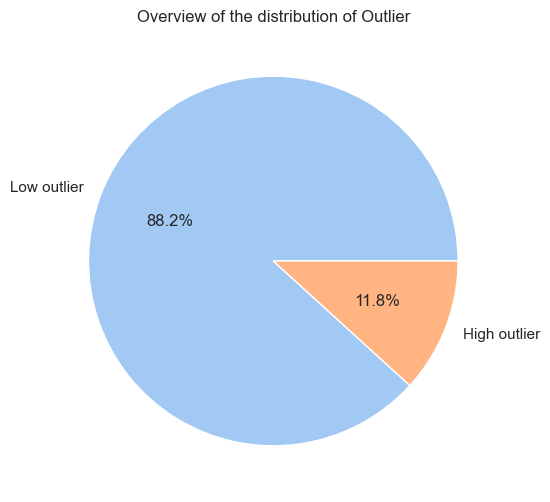

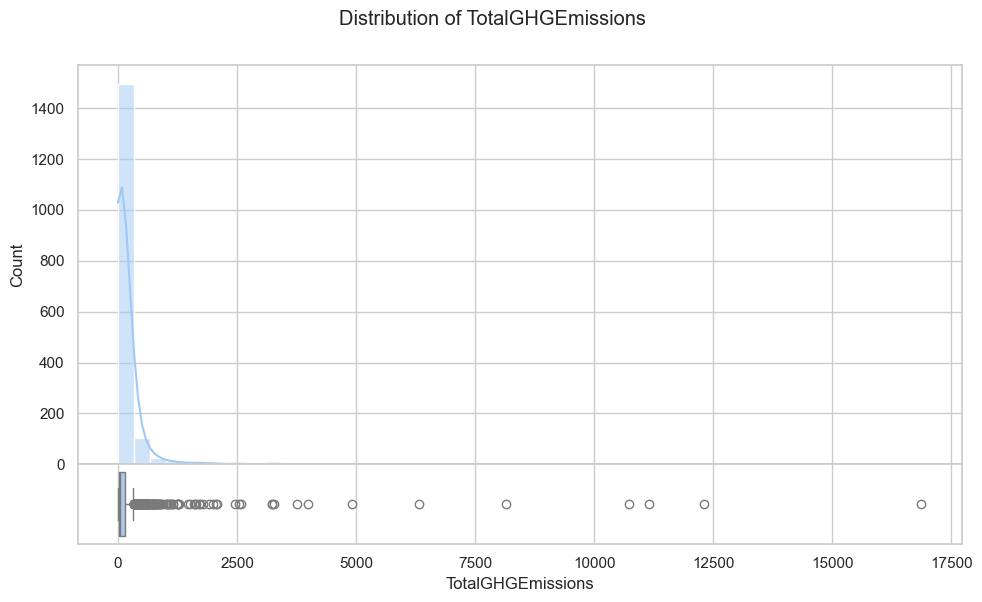

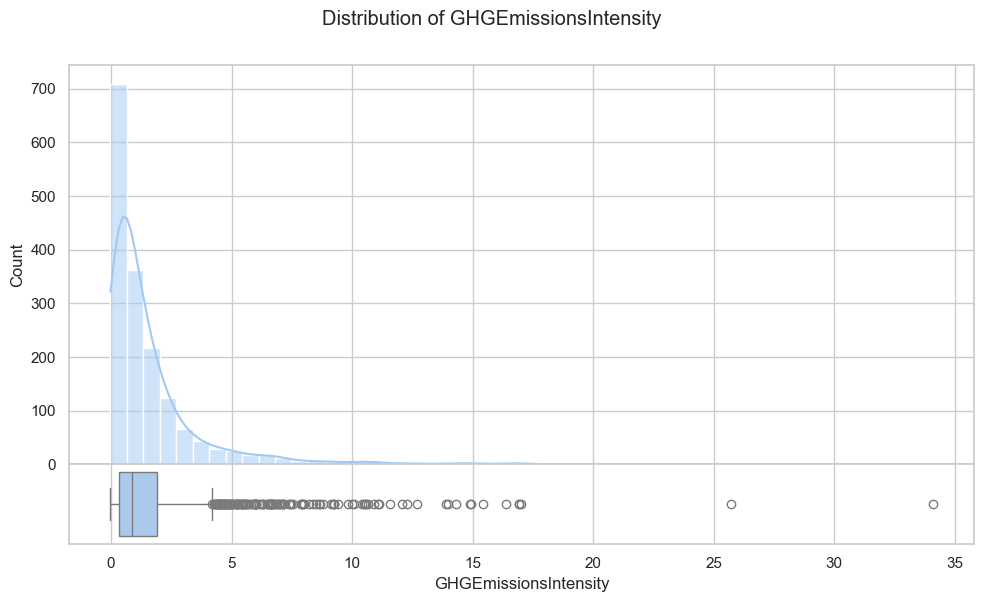

In [332]:
overview_univariate_distributions(building_energy_benchmarking)

Here's what to keep in mind after looking at all those graphs:

- Some outliers need further investigation. In the mean type, investigate the meaning of "Outlier" feature.
- Some column names are really similar (SiteEnergyUse and SiteEnergyUseWN for example - WN means Weather Normalized here), those features should be compared. Some of those simlilar features only seem to have different units, so correlations should be checked, of course. 


In [333]:
def draw_heatmap(corr_matrix:pd.DataFrame, **plot_params):
    '''
    Draws a heatmap for the given correlation matrix.

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix to visualize.
    '''
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr_matrix, ax=ax, mask=mask, center=0, **plot_params)
    ax.set_title("Correlation matrix", size=16)
    plt.plot()


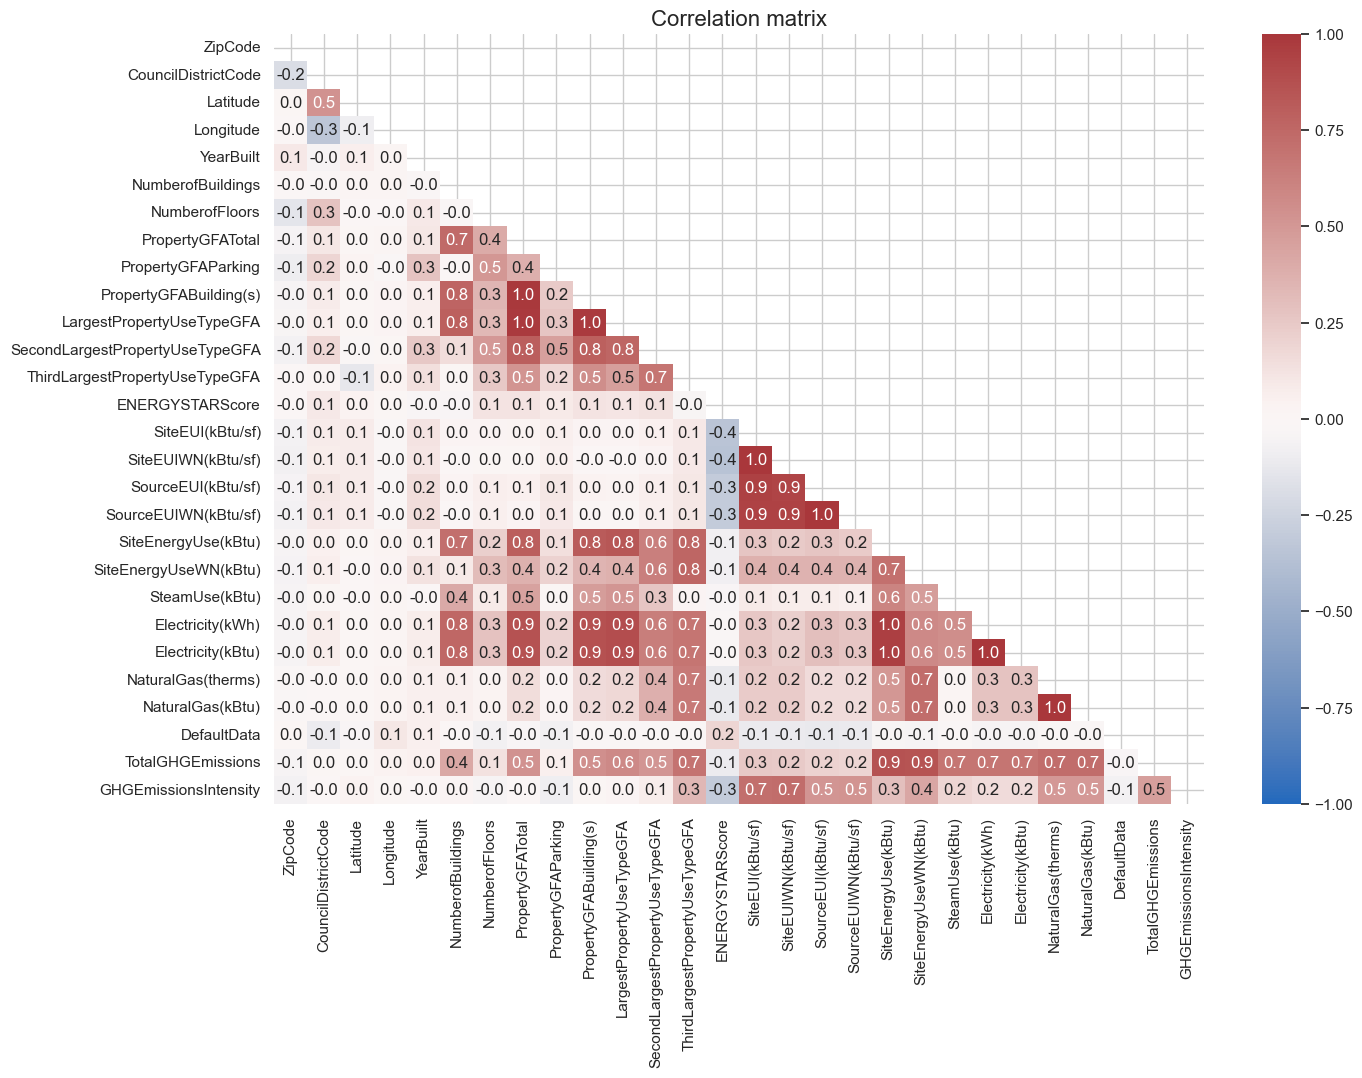

In [334]:
draw_heatmap(building_energy_benchmarking.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, fmt=".1f", cmap='vlag')

### Visualize missing values

<Axes: >

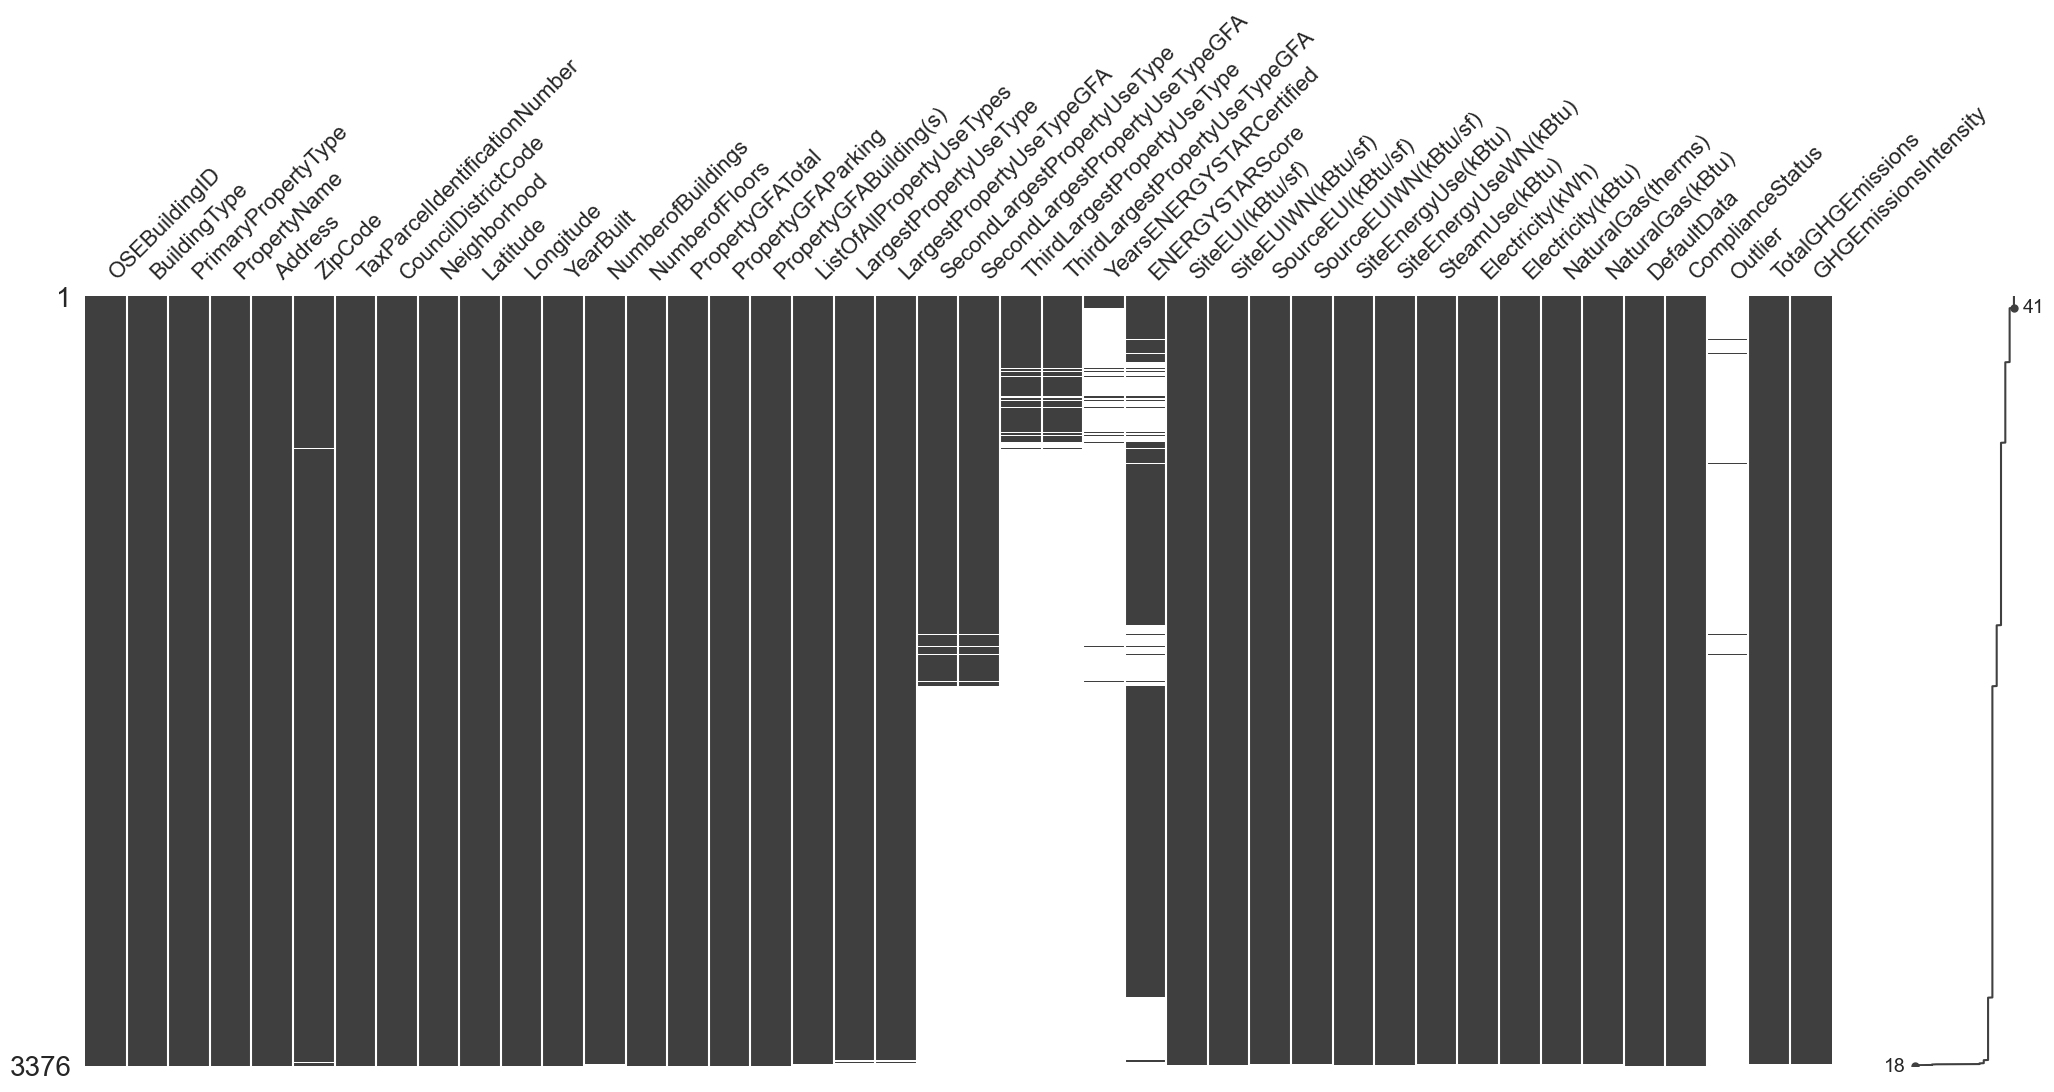

In [247]:
msno.matrix(building_energy_benchmarking, sort="descending")

<Axes: >

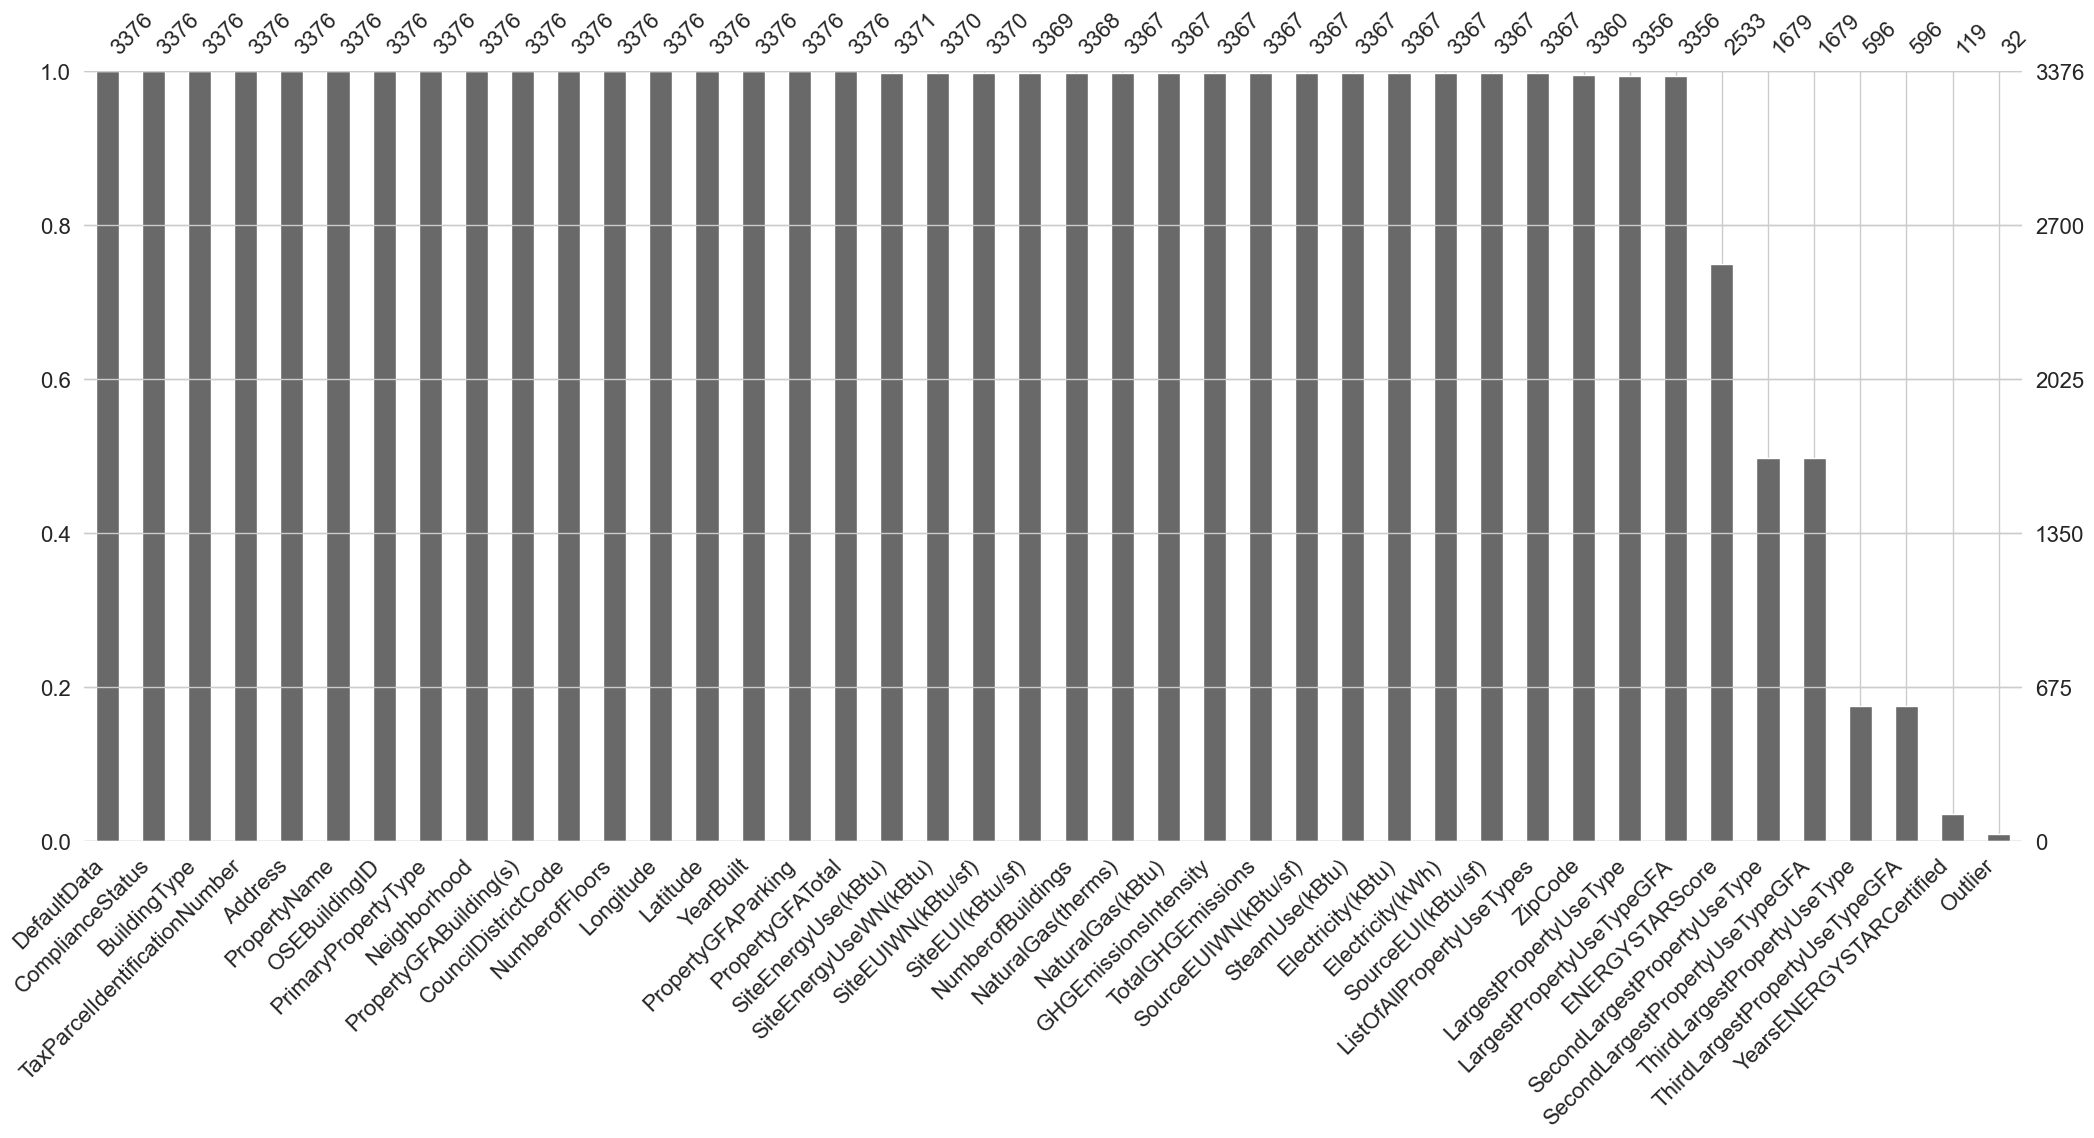

In [248]:
msno.bar(building_energy_benchmarking, sort="descending")

### Fix dtypes